### Advanced Lane Project

The steps in this process is 

* Compute the Camera Calibration matrix and Distortion coefficients on chessboard images.
* Apply a distortion correction to camera images
* Create a thresholded binary image using gradients and color transforms
* Do a perspective Transform and get a birds eye view of the binary image
* Identify lane pixels 
* Inverse Transform

#### Imports

In [13]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

#### Check out the chess board images

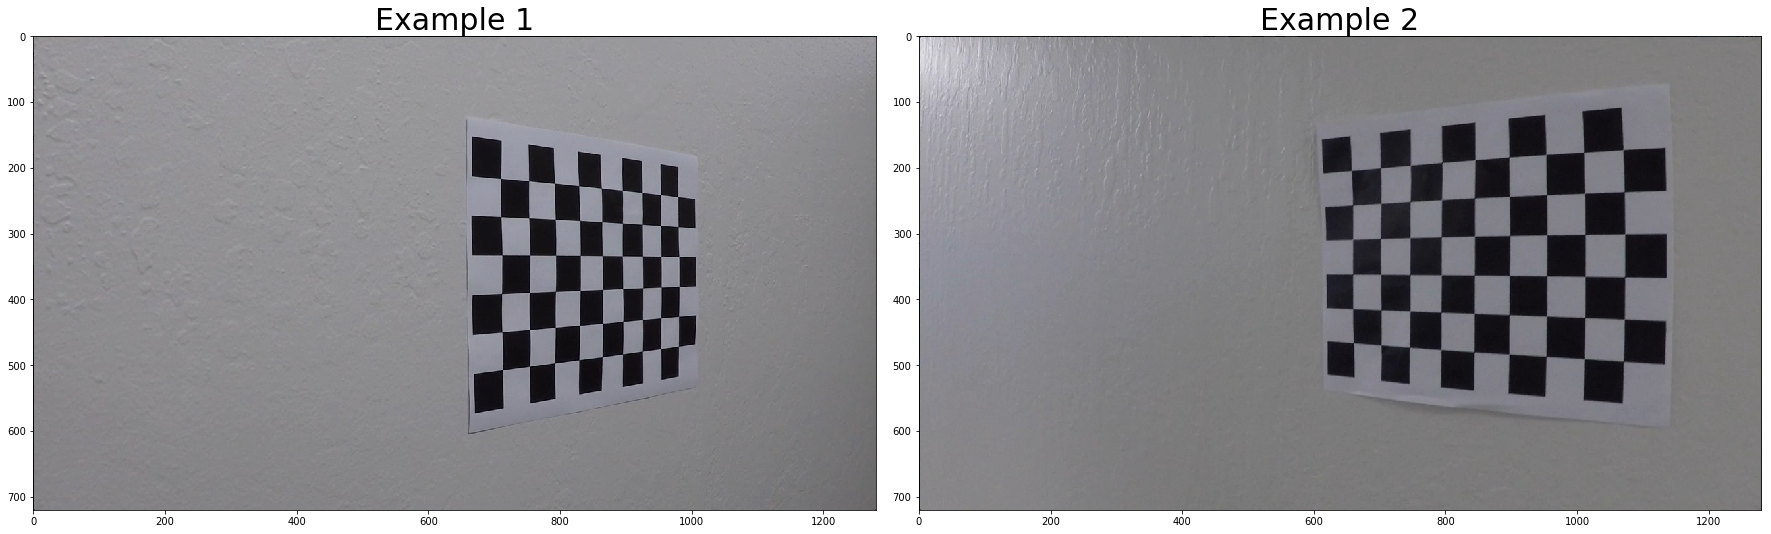

In [14]:
#sample image 

images_chess = glob.glob('camera_cal/*.*')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread(images_chess[3]))
ax1.set_title('Example 1', fontsize=30)
ax2.imshow(mpimg.imread(images_chess[5]))
ax2.set_title('Example 2', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### Compute the Camera Calibration matrix and Distortion coefficients on chessboard images.

In [15]:
# There are 9 corners in a row where black and white spaces meet, hence nx = 9
# There are 6 corners in a column where black and white spaces meet, hence ny = 9
nx = 9
ny = 6

# we use the chessboard images that we saw in the previous block to extract object points 
# and image points

objpoints = []
imgpoints = []

objpts = np.zeros((nx*ny,3), np.float32)
objpts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

images_chess = glob.glob('camera_cal/*.*')

for image in images_chess:
    img = mpimg.imread(image)
    
    shape = img.shape
    
    #Convert to Gray Scale first 
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # Shouldnt make too much difference, as this is already black and white
    
    #find corners using the gray scaled image
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    if ret:
        objpoints.append(objpts)
        imgpoints.append(corners)
    
# we can now use the object points and image points to get the camera calibration matrix and distortion coeffs

ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape[:2],None,None)



#### Apply a distortion correction to camera images

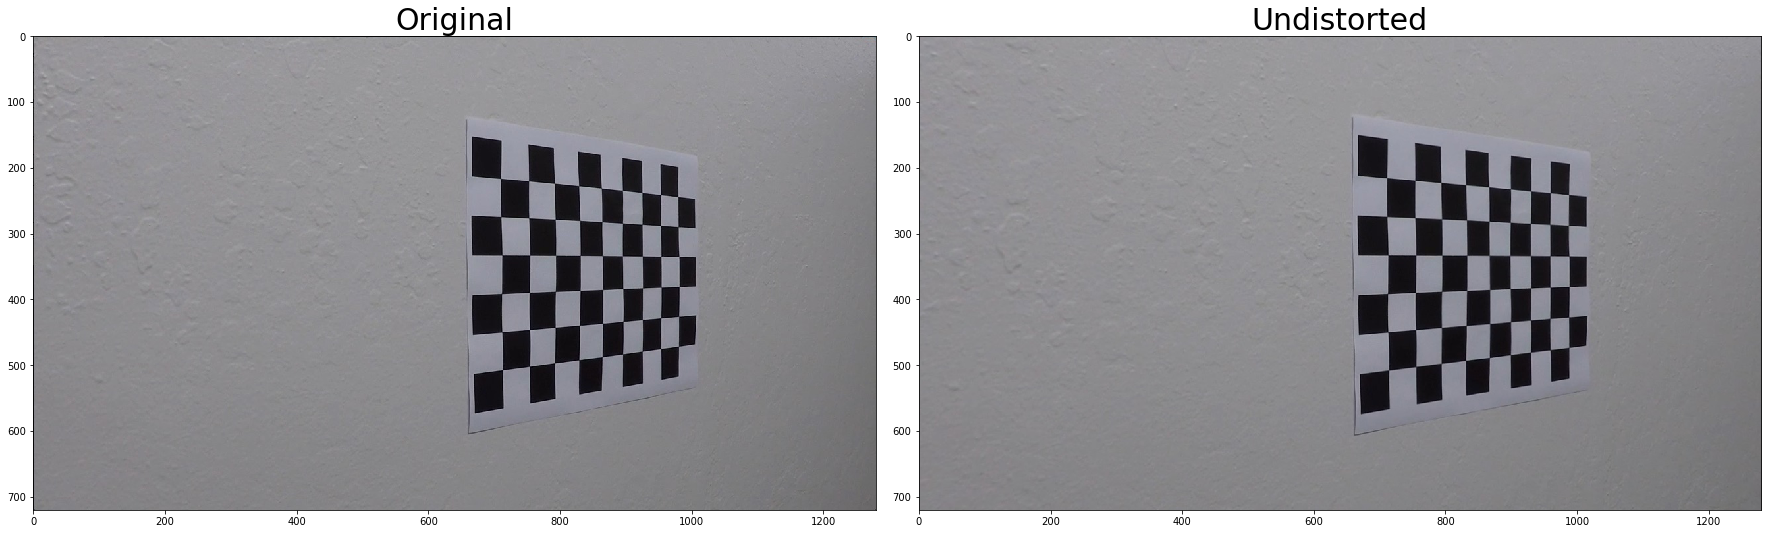

In [16]:
# un distort an image EXAMPLE

image_number = 3

undist = cv2.undistort(mpimg.imread(images_chess[image_number]), cameraMatrix, distortionCoeffs, None, cameraMatrix)


# Show Distorted vs Undistorted

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread(images_chess[image_number]))
ax1.set_title('Original', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




#### Create a thresholded binary image using gradients and color transforms

Gradient Thresholds 

We use different kinds of gradient thresholds 

* Apply sobel filters along the X axis, mostly because the lane lines are vertical 
* Apply directional gradient thresholds


Color Transforms

* We filter along the R and G channels to isolate Yellow lines
* S Channel filter to separate yellow and white lines from the above image
* L channel filter to discard edges because of shadows



In [17]:
def apply_sobel(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def directional_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1

    return mask


In [18]:
def threshold_image(img):
    
    img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    sx_binary = apply_sobel(gray, 'x', 10, 200)
    
    dir_binary = directional_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # Threshold for S is (100,255)    
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # Threshold for L is (120,255)
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # Combine the thresholds we have created
    # We use both S_after_threshold and combined threshold to detect Yellow and White, 
    # We use an OR condition because if a pixel satisfies either of these conditions, it is yellow and white
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    


#### Original vs Undistorted

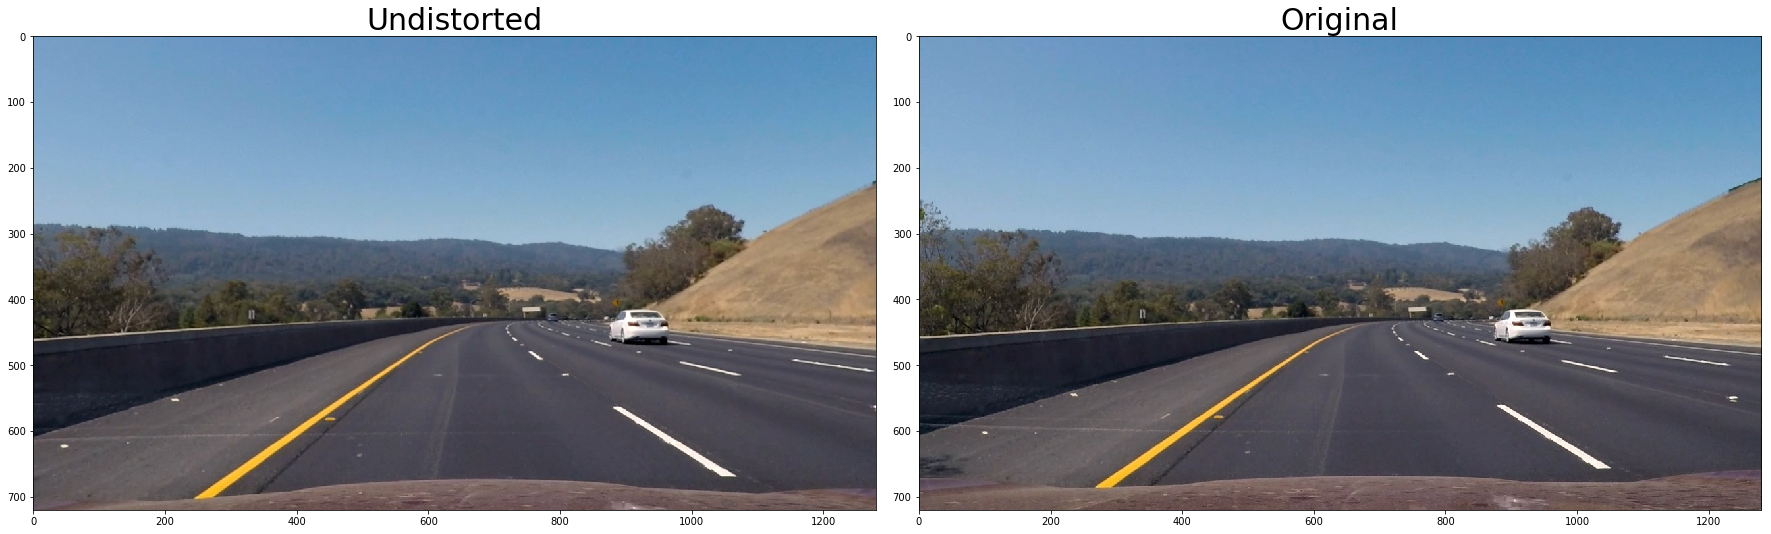

In [19]:
# image EXAMPLE

n = 7
images_road = glob.glob('test_images/*.*')

undist = cv2.undistort(mpimg.imread(images_road[n]), cameraMatrix, distortionCoeffs, None, cameraMatrix)
orig = mpimg.imread(images_road[n])



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax2.imshow(orig)
ax2.set_title('Original', fontsize=30)
ax1.imshow(undist,cmap='gray')
ax1.set_title('Undistorted', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Create a Binary image using the threshold_image function

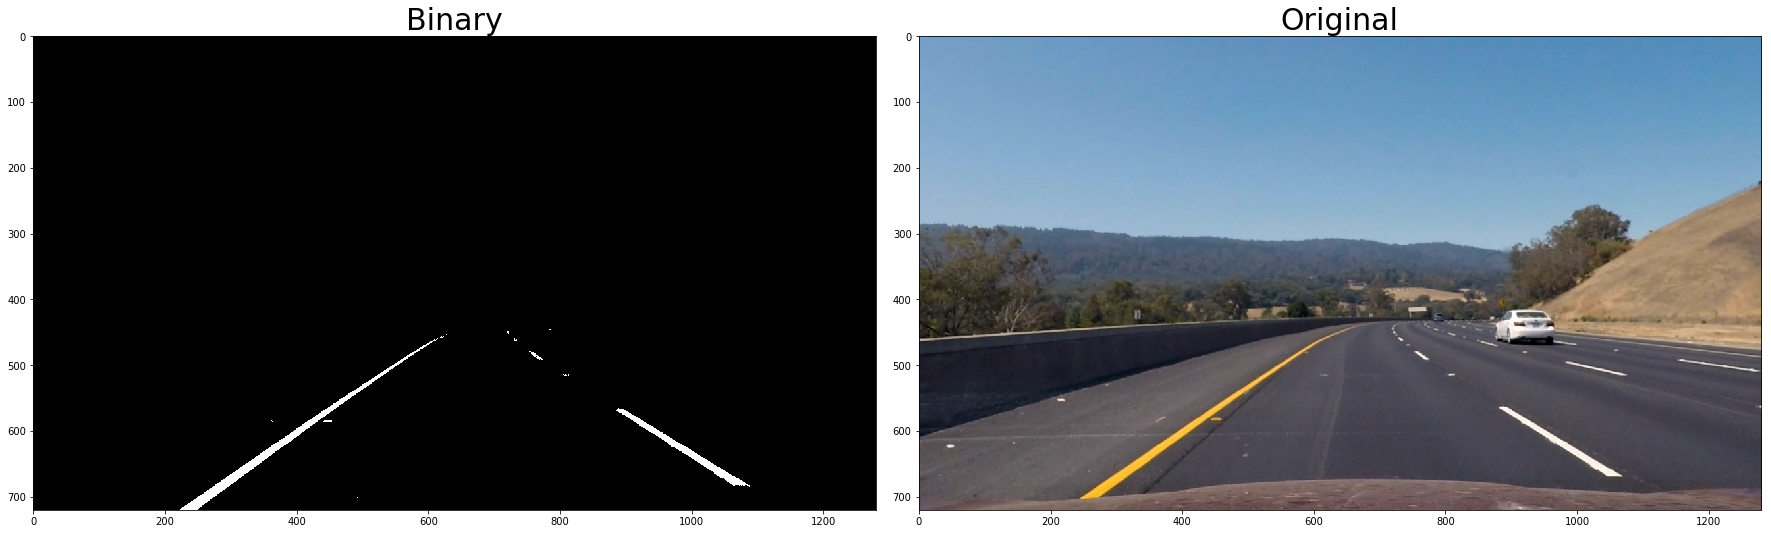

In [20]:
# image EXAMPLE

n = 7
images_road = glob.glob('test_images/*.*')

undist = cv2.undistort(mpimg.imread(images_road[n]), cameraMatrix, distortionCoeffs, None, cameraMatrix)
thresh = threshold_image(undist)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax2.imshow(undist)
ax2.set_title('Original', fontsize=30)
ax1.imshow(thresh,cmap='gray')
ax1.set_title('Binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### Do a perspective transform

We do a perspective transform to adjust the veiwing angle of images. In this case, we define the points manually in the original image and then do a transform from the top down


We choose the source points manually by examining the previous cell

Destination points are chosen such that we have a top down view of the selected points

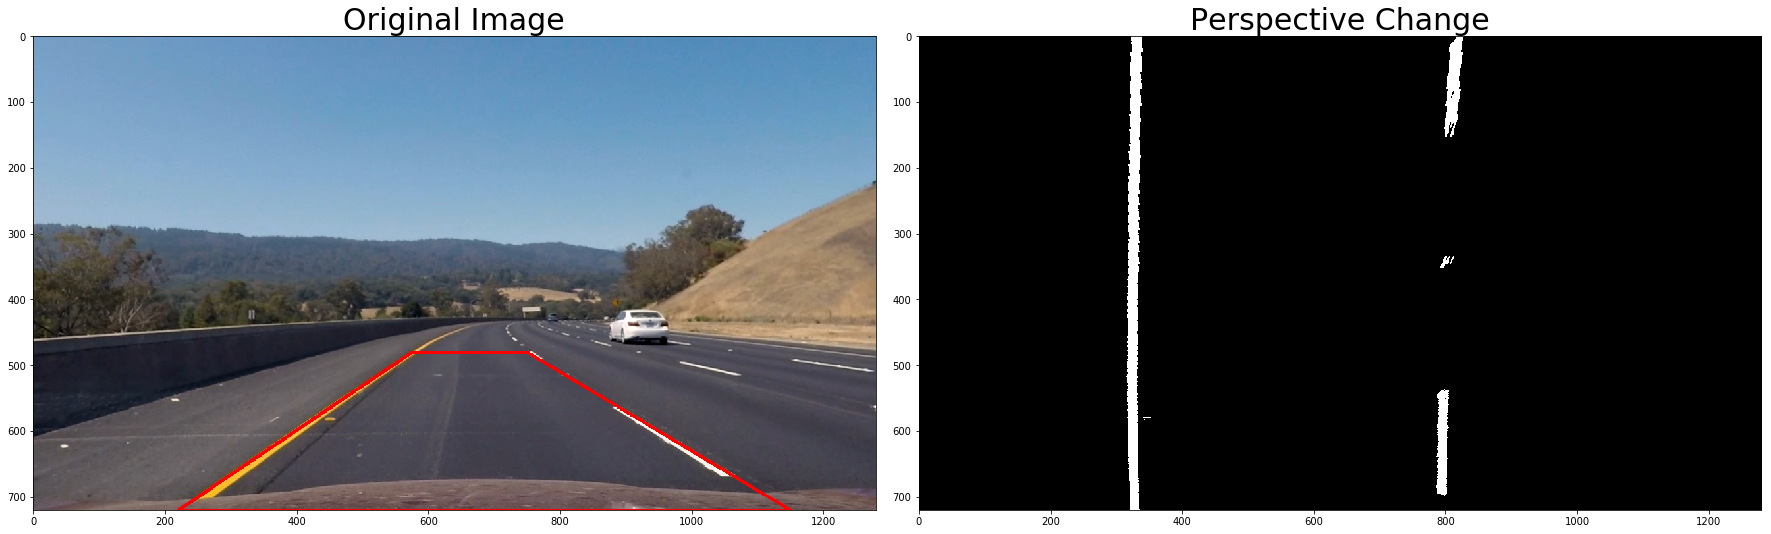

In [21]:
bottom_left = [220,720]
bottom_right = [1150,720]
top_left = [575,480]
top_right = [750,480]



pts1 = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts2 = pts1.reshape((-1,1,2))

#draw polygon on the original image

copy1 = undist.copy()
cv2.polylines(copy1,[pts2],True,(255,0,0), thickness=3)

# plt.imshow(copy1)
# plt.show()


# Destination Points

d_bottom_left = [320,720]
d_bottom_right = [800, 720]
d_top_left = [320, 1]
d_top_right = [800, 1]

source = np.float32([bottom_left,bottom_right,top_right,top_left])
dest = np.float32([d_bottom_left,d_bottom_right,d_top_right,d_top_left])

matrix = cv2.getPerspectiveTransform(source,dest)
M_inv = cv2.getPerspectiveTransform(dest, source)
image_size = (undist.shape[1],undist.shape[0])

P_changed = cv2.warpPerspective(thresh, matrix, image_size , flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(P_changed, cmap='gray')
ax2.set_title('Perspective Change', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Identify lane pixels

#### Step 1 : The Peaks in the histogram tell us where the lane lines are

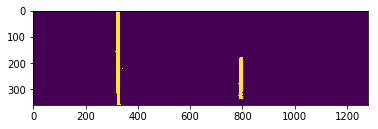

In [22]:
# The first half of the perspective warped image is likely to have the lane lines. It is shown below

plt.imshow(P_changed[int(P_changed.shape[0]/2):,:])
plt.show()

The lanes start at 321 and 797


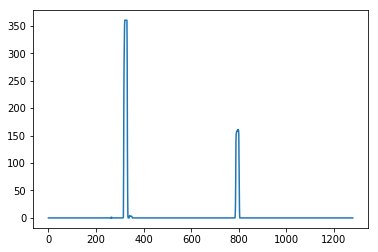

In [23]:
# we take the sum of all values in each row. This gives us the sum of concentration of pixels in each row

hist = np.sum(P_changed[int(P_changed.shape[0]/2):,:],axis=0)
half_of_hist = np.int(hist.shape[0]/2)
# Peak in the first half is left lane
left_lane_hist = np.argmax(hist[:half_of_hist])
# Peak in second half is right lane
right_lane_hist = np.argmax(hist[half_of_hist:]) + half_of_hist
print("The lanes start at {} and {}".format(left_lane_hist, right_lane_hist))
plt.plot(hist)

#### Step 2 : Siding Window Approach

We use the positions of the lanes we found from the histogram and use the sliding window search. We create 10 windows with minimum number of pixes of 100

We then fit a polynomial to all the non zero x and y pixels to determine where the lane lines go 


In [24]:
out_img = np.dstack((P_changed, P_changed, P_changed))*255

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = P_changed.nonzero()
nonzeroy = nonzero[0]
nonzerox = nonzero[1]

# Set the width of the windows +/- margin
margin = 100

# Choose the number of sliding windows
nwindows = 10
num_rows = P_changed.shape[0]

# Set height of windows - based on nwindows above and image shape
window_height = np.int(num_rows/nwindows)
print('Window Height is {}'.format(window_height))
window_half_width = 50

# Set minimum number of pixels found to recenter window
minpix = 100

# Current positions to be updated later for each window in nwindows
leftx_current = left_lane_hist
rightx_current = right_lane_hist

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = P_changed.shape[0] - (window+1)*window_height
    win_y_high = P_changed.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
    (win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
    (win_xright_high,win_y_high),(0,255,0), 2) 

    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices (previously was a list of lists of pixels)
try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]



Window Height is 72


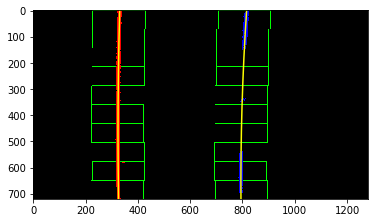

In [25]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')


    return left_fit,left_fitx, right_fit, right_fitx,ploty, out_img


left_fit,left_fitx, right_fit, right_fitx,ploty, out_img = fit_polynomial(P_changed)

plt.imshow(out_img)

#### Step 3 : Search From Prior Frame

Because we have already found the lane positions in the previous step, we dont have to rerun the entire algorithm again. This is because Lane Lines dont really change all that much. 

So we can use prior frames

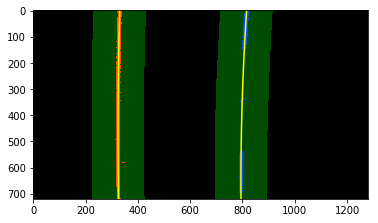

In [26]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = P_changed

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

#### Step 4 : Measure Radius of Curvature

In [27]:
import numpy as np



def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

16311.3239908 9852.43316953


#### Inverse Transform

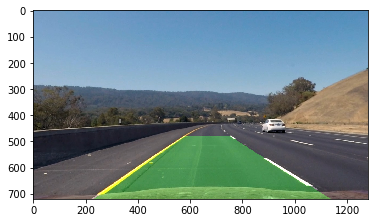

In [28]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(out_img, M_inv, image_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)

plt.imshow(result)

## Final Pipeline

#### Calculate the radius of curvature and center offset

We use the classroom material for the formula of radius of curvature. The idea is that, we have to calculate the radius of curvature in meters while we perform the polynomial fit in pixels. Hence, we have to use a pixel to meter conversion

* The center of the image gives us the position of the car
* The mean of the pixels closest to the car gives us the center of the lane

The difference between these two will give us the offset from the center

In [46]:
def measure_roc_co(x_values):
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

In [68]:
# Declare global variables
polyfit_left=None
polyfit_right=None

previous_good_left = []
previous_good_right = []

mean_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):

    # This function generates a prediction for the lane line, given the coordinates of the non zero pixes within the
    # sliding window
    
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def search_from_scratch(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[int(warped.shape[0]/2):,:],axis=0)


    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def averaged_line(previous_lines, new_line):

    # This function averages over previous good frames and returns a averaged lane line
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def mean_bw_lines(left_line, right_line, running_average):

    # This returns the weighted average of difference between left and right lane lines
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def finalpipeline(img):
    # Declare global variables
    
    global previous_good_right
    global previous_good_left
    
    global mean_between_lines
    
    global polyfit_right
    global polyfit_left
    

    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    thresholded = threshold_image(img)
    
    warped = cv2.warpPerspective(thresholded, matrix, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        brute = True
        left_x_predictions, right_x_predictions = search_from_scratch(warped)
    else:
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = search_from_scratch(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if mean_between_lines == 0:
            mean_between_lines = mean_difference
        
        if (mean_difference < 0.7*mean_between_lines or mean_difference > 1.3*mean_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = search_from_scratch(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*mean_between_lines or mean_difference > 1.3*mean_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(previous_good_left) == 0 and len(previous_good_right) == 0:
            return img
        else:
            left_x_predictions = previous_good_left[-1]
            right_x_predictions = previous_good_right[-1]
    else:
        previous_good_left, left_x_predictions = averaged_line(previous_good_left, left_x_predictions)
        previous_good_right, right_x_predictions = averaged_line(previous_good_right, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        mean_between_lines = 0.9*mean_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_roc_co(left_x_predictions)
    right_curve_rad = measure_roc_co(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    
    # Approx Camera Placement Offset in meter
    lane_offset_bias = -0.5

    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    #center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_pixels = (img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels + lane_offset_bias
    offset_string = "Center offset: %.2f m" % center_offset_mtrs

    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    #cv2.putText(result, offset_string2, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

    return result






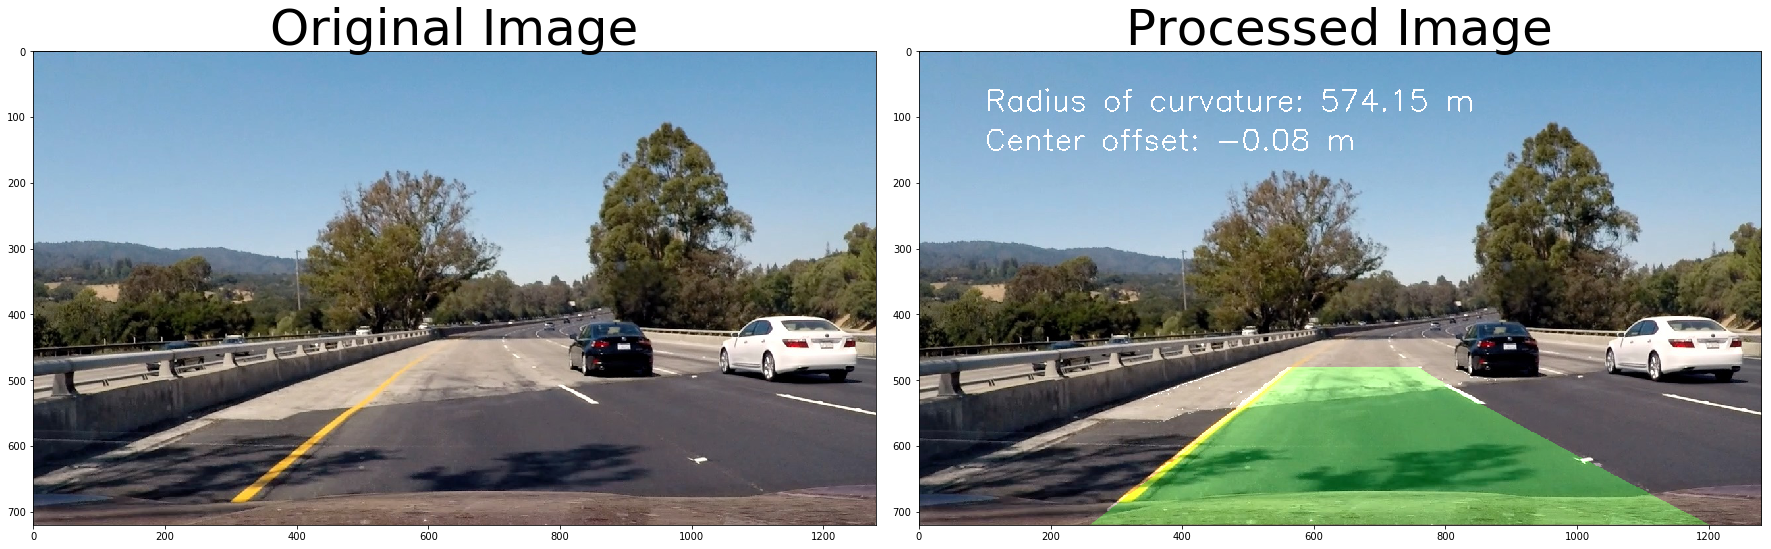

In [69]:
img = mpimg.imread('test_images/test4.jpg')

# Reinitialize some global variables.

polyfit_left=None
polyfit_right=None
previous_good_left = []
previous_good_right = []
mean_between_lines = 0

processed = finalpipeline(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [70]:
from moviepy.editor import VideoFileClip


In [71]:
# Reinitialize some global variables.
polyfit_left=None
polyfit_right=None
previous_good_left = []
previous_good_right = []
mean_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(finalpipeline) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:23<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 48s, sys: 23.6 s, total: 4min 12s
Wall time: 6min 26s
